In [1]:
#import libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_absolute_error

In [89]:
from statsmodels.tsa.arima.model import ARIMA

In [3]:
import pandas as pd
rainfall_data = pd.read_csv('rainfall_data.zip')
rainfall_data.head()

Year  Month  Day  Specific Humidity  Relative Humidity  Temperature  \
0  2000      1    1               8.06              48.25        23.93   
1  2000      2    1               8.73              50.81        25.83   
2  2000      3    1               8.48              42.88        26.68   
3  2000      4    1              13.79              55.69        22.49   
4  2000      5    1              17.40              70.88        19.07   

   Precipitation  
0           0.00  
1           0.11  
2           0.01  
3           0.02  
4         271.14

In [5]:
#combine the columns into a timestamp column and set it as  the index
rainfall_data['timestamp'] = pd.to_datetime(rainfall_data[['Year','Month','Day']])
rainfall_data.drop(columns = ['Year','Month','Day'],axis = 1, inplace = True)
rainfall_data.set_index('timestamp', inplace=True)
rainfall_data.head()

Specific Humidity  Relative Humidity  Temperature  Precipitation
timestamp                                                                   
2000-01-01               8.06              48.25        23.93           0.00
2000-02-01               8.73              50.81        25.83           0.11
2000-03-01               8.48              42.88        26.68           0.01
2000-04-01              13.79              55.69        22.49           0.02
2000-05-01              17.40              70.88        19.07         271.14

In [7]:
# we are going to focus on temperature
df = rainfall_data[['Temperature']] 
df.head()

Temperature
timestamp              
2000-01-01        23.93
2000-02-01        25.83
2000-03-01        26.68
2000-04-01        22.49
2000-05-01        19.07

### Time series plot

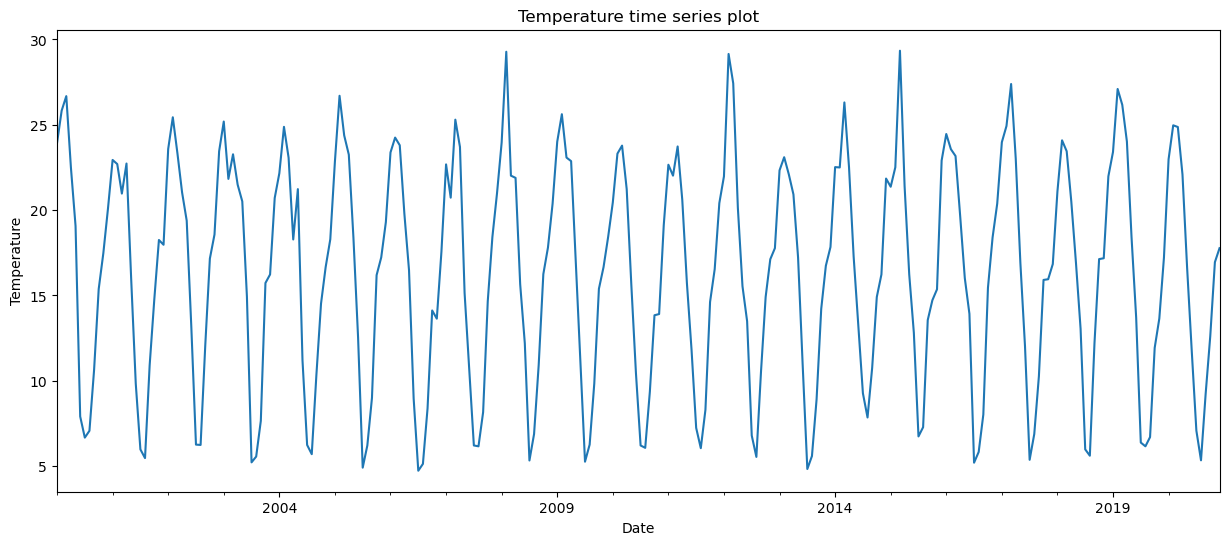

In [25]:
#timeseriesplot
fig, ax = plt.subplots(figsize=(15, 6))
df['Temperature'].plot(xlabel ='Date', ylabel ='Temperature',ax=ax, title = 'Temperature time series plot');

### rolling average

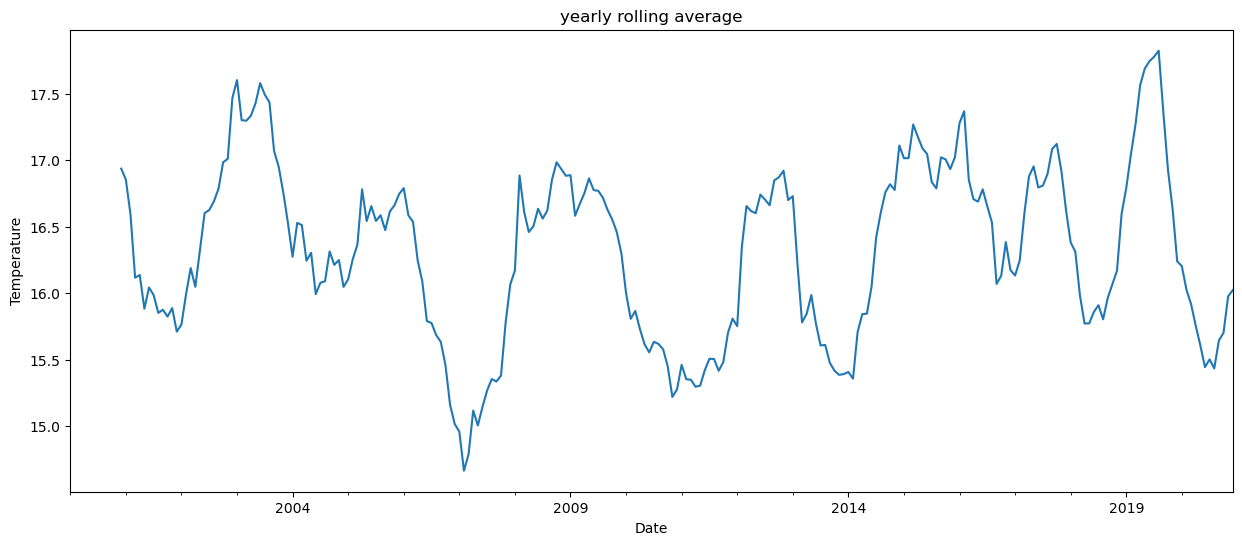

In [27]:
# calculate rolling average
#data is recorded monthly (specifically on the first of each month) for 12 months in a year
#so we will use a window of 12
#from 2000 to 2020
fig, ax = plt.subplots(figsize=(15, 6))
df["Temperature"].rolling( window = 12).mean().plot(ax=ax,
                                  ylabel ='Temperature',
                                  xlabel='Date',
                                  title ='yearly rolling average');

#### from the plot above we see that our data is stationary, the mean and variance dont change that much(no observed trend)

### autocorrelation, acf and pcf

In [30]:
# create T.L1 column that creates values from the previous month
#since the new feature creates nan values we drop them
df['Temperature.L1'] = df['Temperature'].shift(1)
df.dropna(inplace =True)
df.head()

C:\Users\HP\AppData\Local\Temp\ipykernel_12164\3050992079.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Temperature.L1'] = df['Temperature'].shift(1)
C:\Users\HP\AppData\Local\Temp\ipykernel_12164\3050992079.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace =True)


Temperature  Temperature.L1
timestamp                              
2000-02-01        25.83           23.93
2000-03-01        26.68           25.83
2000-04-01        22.49           26.68
2000-05-01        19.07           22.49
2000-06-01         7.91           19.07

In [31]:
#correlation coefficient
df.corr()

Temperature  Temperature.L1
Temperature        1.000000        0.807661
Temperature.L1     0.807661        1.000000

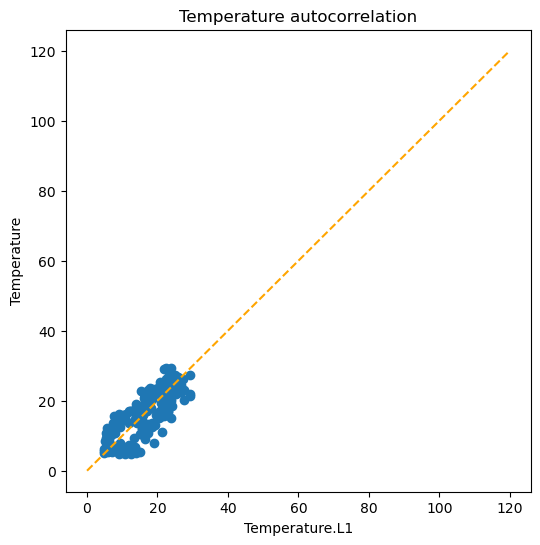

In [32]:
#autocorrelation plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x= df['Temperature.L1'], y= df['Temperature'])
ax.plot([0,120],[0,120], linestyle ='--',color ='orange')
plt.xlabel('Temperature.L1')
plt.ylabel('Temperature')
plt.title('Temperature autocorrelation');

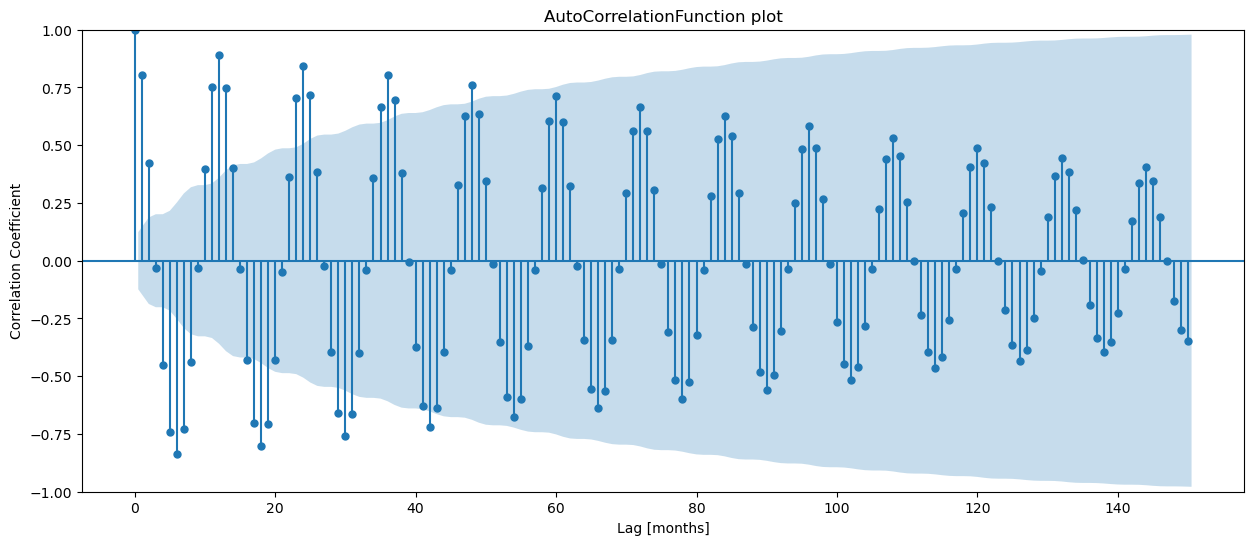

In [33]:
#acf plot
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(df['Temperature'],ax=ax, lags =150)
plt.xlabel("Lag [months]")
plt.ylabel("Correlation Coefficient")
plt.title('AutoCorrelationFunction plot');

#### basing on the acf above, we see a slow decay and peaks at regular intervals we are most likely dealing with an auto regressive process,& seasonal differencing

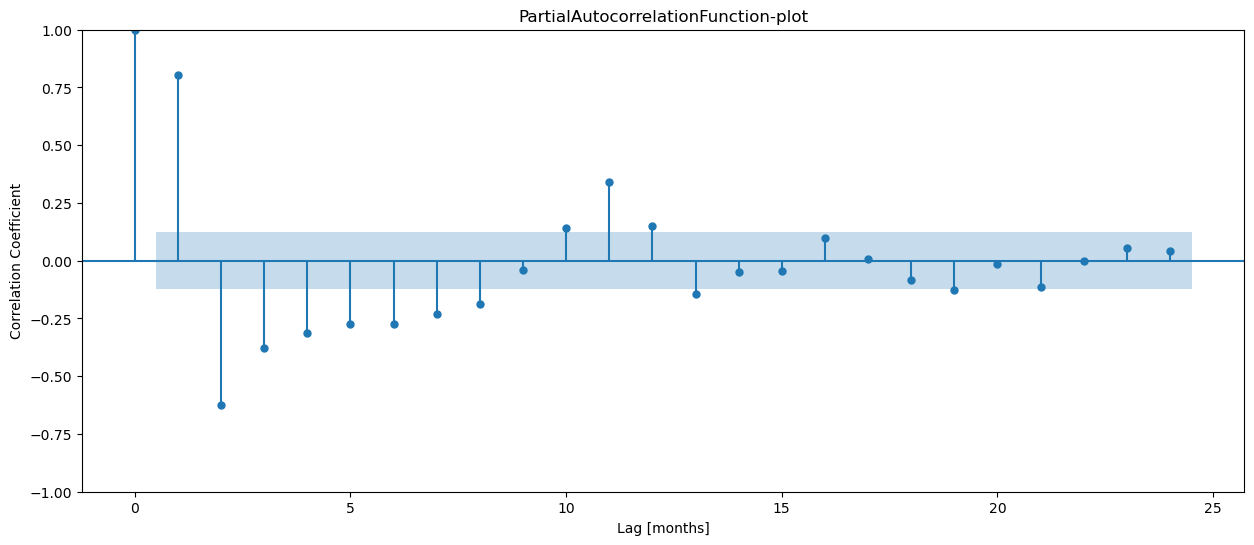

In [35]:
#pacf plot
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(df['Temperature'], ax = ax)
plt.xlabel("Lag [months]")
plt.ylabel("Correlation Coefficient")
plt.title('PartialAutocorrelationFunction-plot');

#### basing on the pacf above we can start our autoregressive model with lags(1,2,3,4,5,6,7,8,11), exponential decay,sine function, significant peak at lag 11-12(indicating seasonality)

## model building(autoreg)

In [38]:
#split data
target = "Temperature"
y = df[target]
cutoff_test = int(0.8*len(y))

y_train = y.iloc[0:cutoff_test]
y_test = y.iloc[cutoff_test:]

In [39]:
#baseline
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean P2 Reading:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean P2 Reading: 16.24
Baseline MAE: 5.59


In [40]:
# Hyperparameter tuning
from sklearn.model_selection import TimeSeriesSplit


# Define the range of p values to search
p_values = range(1, 13)

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

mae_grid = {}
for p in p_values:
    mae_grid[p] = []
    for train_index, test_index in tscv.split(y):
        y_train_split, y_test_split = y.iloc[train_index], y.iloc[test_index]
        model = AutoReg(y_train_split, lags=p).fit()
        y_pred = model.predict(start=len(y_train_split), end=len(y_train_split) + len(y_test_split) - 1)
        mae = mean_absolute_error(y_test_split, y_pred)
        mae_grid[p].append(mae)

print(mae_grid)



C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will conta

{1: [5.944993819859045, 6.182784172523488, 5.522898553261153, 5.525446959588385, 5.662785789160981], 2: [5.833592852325078, 5.65788119523533, 4.901043323595376, 5.24394213871321, 5.057920910367479], 3: [5.451292523858136, 5.207530109921606, 4.642548510100461, 4.8250544264751705, 4.688561693663882], 4: [5.162251269736656, 4.5505702228756695, 4.423396577440095, 4.423581118722969, 4.036754046659271], 5: [3.966332535137753, 4.195605023355826, 3.3944795675264654, 3.7044428051703315, 3.100294683641927], 6: [2.864673304692503, 3.8333264061689944, 2.4944583270755354, 3.096752680040398, 2.3508361311592236], 7: [2.7260728641980254, 3.703774224842423, 1.9965416971304986, 2.751435098471517, 1.9106053763518283], 8: [2.359494140849565, 3.700958592258056, 1.6538658227848346, 2.509881884050122, 1.8242435036279028], 9: [2.3034419770557184, 3.9709958665389906, 1.6246448054439966, 2.605797437312685, 1.8433992111294069], 10: [2.3861430237390704, 3.895288098517279, 1.5278418425344258, 2.231201221514699, 1.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will conta

In [41]:
# Calculate the mean MAE for each p
mean_mae = {p: sum(mae_values) / len(mae_values) for p, mae_values in mae_grid.items()}

# Find the best p with the minimum mean MAE
best_p = min(mean_mae, key=mean_mae.get)

# Print the results
print("Mean MAE for each p:", mean_mae)
print("Best p:", best_p)

Mean MAE for each p: {1: 5.767781858878611, 2: 5.338876084047294, 3: 4.962997452803851, 4: 4.5193106470869315, 5: 3.672230922966461, 6: 2.928009369827331, 7: 2.6176858521988584, 8: 2.4096887887140963, 9: 2.46965585949616, 10: 2.367276903564423, 11: 1.7176387863962517, 12: 1.755559216447828}
Best p: 11


In [42]:
#instantiate model
model =  AutoReg(y_train,lags=11).fit()

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [43]:
#evaluating the autoreg model on train data
y_pred = model.predict().dropna()
training_mae = mean_absolute_error(y_train.iloc[11:], y_pred)
print("Training MAE:", training_mae)

Training MAE: 1.5507506647225373


### visualize residuals

In [45]:
y_train_resid = model.resid
y_train_resid.tail()

timestamp
2016-05-01    0.295460
2016-06-01    3.176725
2016-07-01   -3.854846
2016-08-01   -1.596255
2016-09-01   -1.933598
dtype: float64

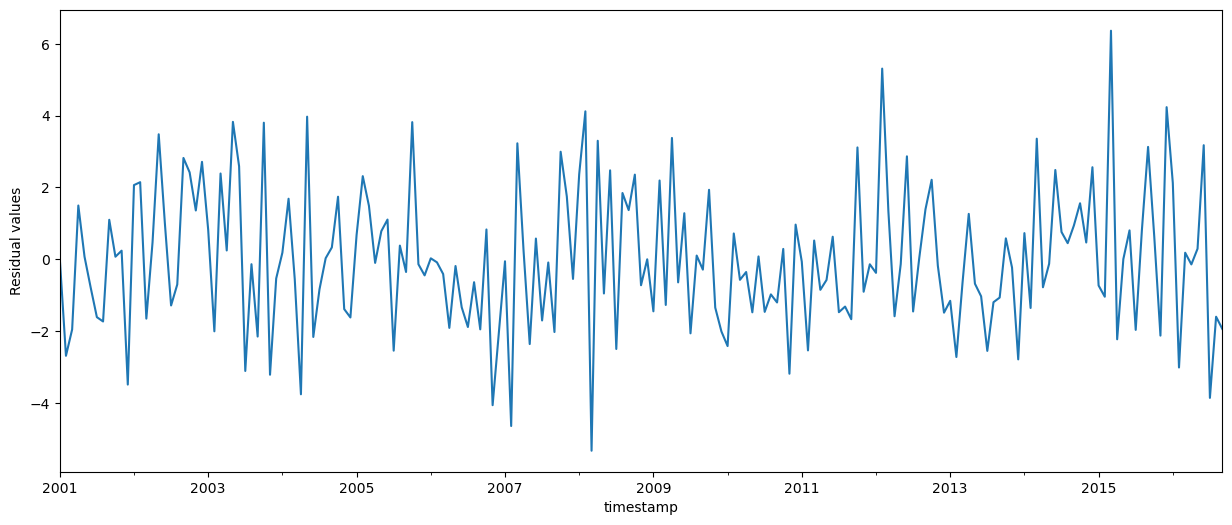

In [46]:
#time series plot of the residuals
fig, ax = plt.subplots(figsize=(15, 6))
y_train_resid.plot(ax=ax, ylabel='Residual values');

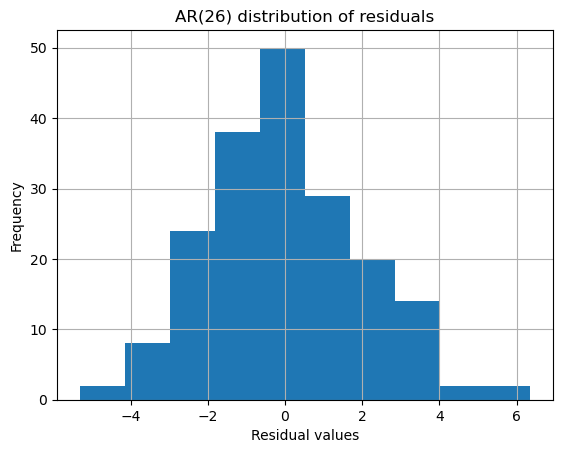

In [47]:
#histogram of the residuals(should be normally distributed)
y_train_resid.hist()
plt.xlabel('Residual values')
plt.ylabel('Frequency')
plt.title('AR(26) distribution of residuals');

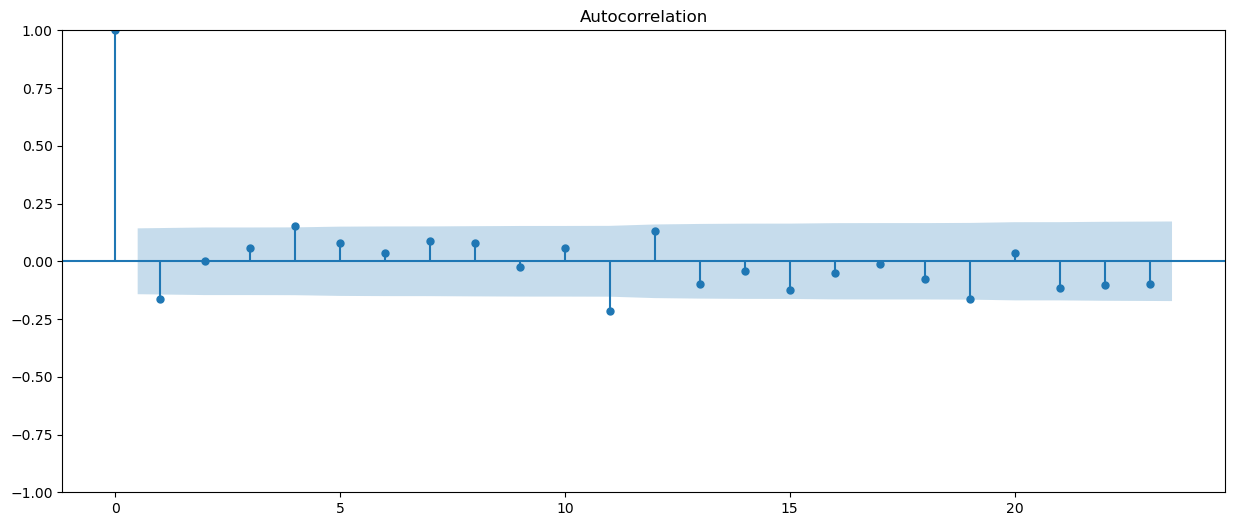

In [48]:
#create an acf plot of the residuals
#our acf plot should show that there is no autocorrelation
# no more signal left in our data
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y_train_resid, ax=ax);

### evaluation using the test data

In [50]:
y_pred_test = model.predict(y_test.index.min(),y_test.index.max())
test_mae = mean_absolute_error(y_test, y_pred_test)
print("Test MAE:", test_mae)

Test MAE: 1.7352704805431352


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


C:\Users\HP\anaconda3\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  v = v.dt.to_pydatetime()


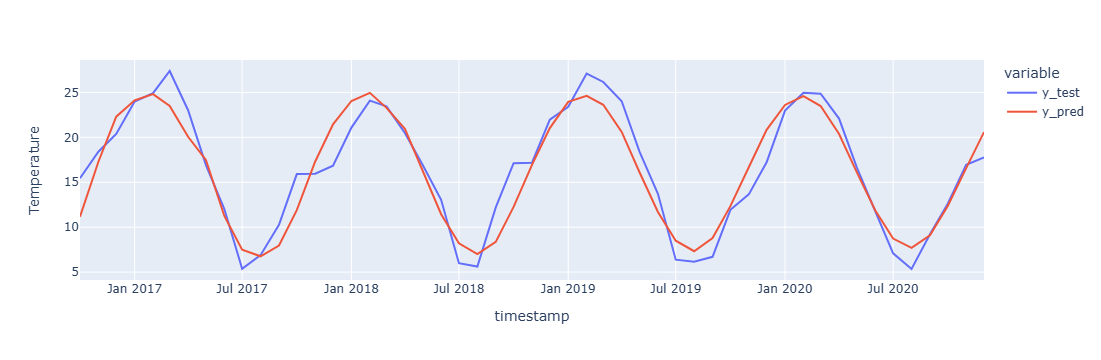

In [51]:
df_pred_test = pd.DataFrame(
    {"y_test": y_test, "y_pred": y_pred_test}, index=y_test.index
)

fig = px.line(df_pred_test, labels={"value": "Temperature"})
fig.show()


### perform walk forward validation(we see an improvement in model performance)

In [74]:
%%capture

y_pred_wfv = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
    model = AutoReg(history, lags=11).fit()
    next_pred = model.forecast()
    y_pred_wfv = pd.concat([y_pred_wfv, pd.Series(next_pred)], ignore_index=True)
    history = pd.concat([history, pd.Series(y_test.iloc[i:i+1])], ignore_index=True)

In [76]:
#evaluation on test data for the autoreg model-wfv
test_mae = mean_absolute_error(y_test,y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 1.63


## model building (ARIMA)

In [80]:

!pip install pmdarima
import pmdarima
from pmdarima import auto_arima
 

   ---------------------------------------- 0.0/614.7 kB ? eta -:--:--
   ---------------------------------------- 0.0/614.7 kB ? eta -:--:--
   ----------------- ---------------------- 262.1/614.7 kB ? eta -:--:--
   ---------------------------------------- 614.7/614.7 kB 1.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   --- ------------------------------------ 0.3/2.8 MB ? eta -:--:--
   ----------- ---------------------------- 0.8/2.8 MB 1.8 MB/s eta 0:00:02
   --------------- ------------------------ 1.0/2.8 MB 2.0 MB/s eta 0:00:01
   ------------------ --------------------- 1.3/2.8 MB 1.5 MB/s eta 0:00:01
   ---------------------- ----------------- 1.6/2.8 MB 1.4 MB/s eta 0:00:01
   -------------------------- ------------- 1.8/2.8 MB 1.3 MB/s eta 0:00:01
   ------------------------------ --------- 2.1/2.8 MB 1.4 MB/s eta 0:00:01
   --------------------------------- ------ 2.4/2.8 MB 1.3 MB/s eta 0:00:01
   --------------------------------

### Hyperparameter tuning  to get order

In [84]:
#hyperparameter tuning
#we are using the auto arima
auto_arima(y_train, test='adf',seasonal=True, trace=True, error_action='ignore', suppress_warnings=True)
# Summary of the best model
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.54 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1324.469, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1120.415, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1162.907, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1714.866, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1031.761, Time=0.11 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=1000.147, Time=0.18 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=975.595, Time=0.41 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=956.942, Time=0.52 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=933.687, Time=0.88 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=937.287, Time=0.65 sec
 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=943.307, Time=0.81 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=993.485, Time=0.64 sec

Best model:  ARIMA(5,0,1)(0,0,0)[0] intercept
To

#### perform walk validation with ARIMA model

In [95]:
%%capture

y_pred_arima = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
    model = ARIMA(history, order = (5,0,1)).fit() 
    next_pred_arima = model.forecast()
    y_pred_arima = pd.concat([y_pred_arima, pd.Series(next_pred_arima)], ignore_index=True)
    history = pd.concat([history, pd.Series(y_test.iloc[i:i+1])], ignore_index=True)

In [97]:
#test mae using the  arima model
test_mae = mean_absolute_error(y_test,y_pred_arima)
print("Test MAE for ARIMA (walk forward validation):", round(test_mae, 2))

Test MAE for ARIMA (walk forward validation): 1.67


In [111]:
#predict dataset
model = ARIMA(y_train, order = (5,0,1)).fit()
pred= model.predict(start=len(y_train), end=(len(y)-1),dynamic=True)


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



### Visualize train, test and  model prediction

<Axes: xlabel='timestamp'>

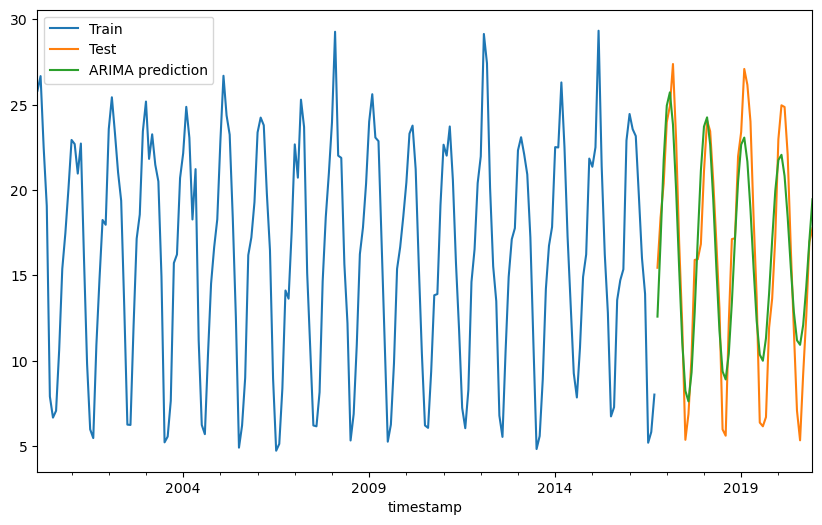

In [113]:
y_train.plot(legend=True, label='Train', figsize=(10,6))

y_test.plot(legend=True, label= 'Test')

pred.plot(legend=True, label='ARIMA prediction')